In [46]:
# antes de empezar importamos la librería de NumPy para poder trabajar con todos sus métodos. 
import numpy as np

# importamos la pandas para poder trabajar en la lección
import pandas as pd

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
#import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest, levene, mannwhitneyu, chi2_contingency, ttest_ind,norm
import scipy.stats as st

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames
pd.set_option('display.max_row', None) # para poder visualizar todas las columnas de los DataFrames

In [12]:
df=pd.read_csv('marketing_AB.csv', sep=',', index_col=0)

Ejercicio 1:
Supongamos que estamos realizando un experimento para determinar si un nuevo diseño de anuncio (test group "ad") tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior (test group "psa").
- Objetivo del ejercicio: Comparar las tasas de conversión entre los grupos de prueba "ad" y "psa" para determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios.
- Pasos que debemos seguir:
    - Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.
    

In [13]:
# vamos a cambiar el nombre de las columnas para que no tengan espacios
columnas = [col.replace(" ", "_") for col in df.columns]
df.columns = columnas

In [14]:
# una vez que tengamos nuestro DataFrame preparado con todas las columnas que queremos vamos a crear una función que no haga una exploración inicial del conjunto de datos
def exploracion_dataframe(dataframe, columna_control):
    """
    Realiza un análisis exploratorio básico de un DataFrame, mostrando información sobre duplicados,
    valores nulos, tipos de datos, valores únicos para columnas categóricas y estadísticas descriptivas
    para columnas categóricas y numéricas, agrupadas por la columna de control.

    Parámetros:
    - dataframe (DataFrame): El DataFrame que se va a explorar.
    - columna_control (str): El nombre de la columna que se utilizará como control para dividir el DataFrame.

    Returns: 
    No devuelve nada directamente, pero imprime en la consola la información exploratoria.
    """
    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {dataframe.duplicated().sum()}")
    print("\n ..................... \n")
    
    
    # generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "object")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col.upper()} tiene las siguientes valore únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    
    
    # como estamos en un problema de A/B testing y lo que realmente nos importa es comparar entre el grupo de control y el de test, los principales estadísticos los vamos a sacar de cada una de las categorías
    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe().T)

In [15]:
df['most_ads_day'].value_counts()

most_ads_day
Friday       92608
Monday       87073
Sunday       85391
Thursday     82982
Saturday     81660
Wednesday    80908
Tuesday      77479
Name: count, dtype: int64

In [16]:
exploracion_dataframe(df,'test_group')

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
user_id,int64
test_group,object
converted,bool
total_ads,int64
most_ads_day,object
most_ads_hour,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna TEST_GROUP tiene las siguientes valore únicos:


,count
test_group,
ad,564577
psa,23524


La columna MOST_ADS_DAY tiene las siguientes valore únicos:


,count
most_ads_day,
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660



 ..................... 

Los principales estadísticos de las columnas categóricas para el AD son: 


,count,unique,top,freq
test_group,564577,1,ad,564577
most_ads_day,564577,7,Friday,88805



 ..................... 

Los principales estadísticos de las columnas numéricas para el AD son: 


,count,mean,std,min,25%,50%,75%,max
user_id,564577.0,1.327314e+06,188918.061566,1000000.0,1163686.0,1327362.0,1490914.0,1654483.0
total_ads,564577.0,2.482337e+01,43.750456,1.0,4.0,13.0,27.0,2065.0
most_ads_hour,564577.0,1.447590e+01,4.841808,0.0,11.0,14.0,18.0,23.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el PSA son: 


,count,unique,top,freq
test_group,23524,1,psa,23524
most_ads_day,23524,7,Thursday,3905



 ..................... 

Los principales estadísticos de las columnas numéricas para el PSA son: 


,count,mean,std,min,25%,50%,75%,max
user_id,23524.0,911761.500000,6790.938202,900000.0,905880.75,911761.5,917642.25,923523.0
total_ads,23524.0,24.761138,42.860720,1.0,4.00,12.0,26.00,907.0
most_ads_hour,23524.0,14.304923,4.656239,0.0,11.00,14.0,18.00,23.0


- Definición de las hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento (en este caso os las damos definidas):
        - Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".
        - Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".
    - Cálculo de la tasa de conversión: Calcula la tasa de conversión para cada grupo:
        - Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.
        - Para el grupo "psa", realiza el mismo cálculo.

In [30]:
def categorizar_grupos(converted):
    if converted == True:
        return 1
    else:
        return 0

In [42]:
grupos=['ad','psa']
lista_tasa=[]
for grupo in grupos:
    df_grupo=df[df['test_group'] ==  grupo]
    df_grupo.groupby('converted')['converted'].count()
    valores_true= df_grupo['converted'].apply(categorizar_grupos).sum()
    print(f'Para el grupo {grupo}, el número de convertidos es: {valores_true}')
    tasa_conversion=valores_true/df_grupo.shape[0]
    lista_tasa.append(tasa_conversion)
    print(f'Para el grupo {grupo}, el la tasa de conversión es: {round(tasa_conversion,4)}')
    print('----------------')
    

Para el grupo ad, el número de convertidos es: 14423
Para el grupo ad, el la tasa de conversión es: 0.0255
----------------
Para el grupo psa, el número de convertidos es: 420
Para el grupo psa, el la tasa de conversión es: 0.0179
----------------


In [43]:
# Crear un DataFrame
data_p_test = {
'Grupo': grupos,
'Tasa_conversión': lista_tasa}

df_p_test = pd.DataFrame(data_p_test)

In [44]:
df_p_test

,Grupo,Tasa_conversión
0,ad,0.025547
1,psa,0.017854


C:\Users\salsi\AppData\Local\Temp\ipykernel_42016\3774327764.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Grupo", y="Tasa_conversión", data=df_p_test,  palette = "viridis");


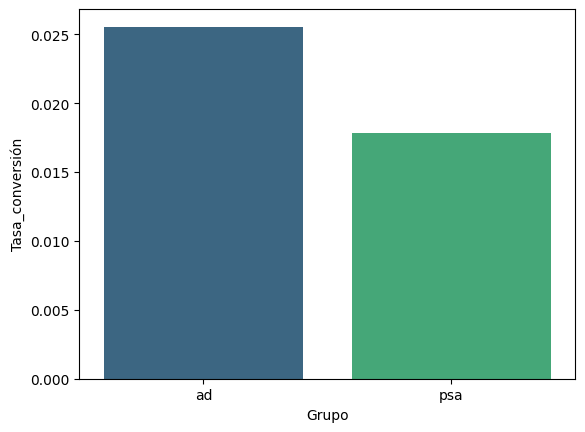

In [45]:
# analizamos los datos primero visualmente
sns.barplot(x="Grupo", y="Tasa_conversión", data=df_p_test,  palette = "viridis");

    - Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student o la prueba chi-cuadrado, para comparar las tasas de conversión entre los grupos "ad" y "psa".
    - Análisis de resultados:
        - Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.
        - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

# Prueba de Proporciones


In [50]:
# Crear una tabla de contingencia
contingency_table = pd.crosstab(df_p_test['Grupo'], df_p_test['Tasa_conversión'])

# Realizar la prueba de proporciones
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Imprimir el resultado de la prueba
alpha = 0.05
if p_value < alpha:
    print("Hay una diferencia significativa en la tasa de conversión de ambos grupos.")
    print("\n ---------- \n")
    print("""
          Los resultados sugieren que si que existe una diferencia entre los grupos 
          """)
else:
    print("No hay evidencia de una diferencia significativa en la tasa de conversión de ambos grupos.")
    print("\n ---------- \n")
    print(""" 
          Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas
          """)

No hay evidencia de una diferencia significativa en la tasa de conversión de ambos grupos.

 ---------- 

 
          Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas
          



    - Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios que el diseño anterior. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.


Basándonos en los resultados, aceptamos la hipótesis nula, es decir, no hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa". Por lo tanto, no vemos necesario implementar la versión con el nuevo diseño.

Ejercicio 2:
En este caso, vamos a realizar un experimento para comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.
- Objetivo del experimento: Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.
Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.
- Hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras
- Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student, para comparar la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa". Esto te permitirá determinar si hay una diferencia significativa entre los dos grupos.
- Análisis de resultados:
    - Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.
    - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.
- Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.
